In [9]:
from GNNModels.Models import *

import torch
from tqdm import tqdm
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Importing the Model

In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset_name = "Cora"

dataset = Planetoid(root='/tmp/Planetoid', name=dataset_name, transform=NormalizeFeatures())
data = dataset[0]  # Get the first graph object.

In [11]:
# This is temporary model training, will be replaced with improting pretrained model, having problems with it currently

from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)

model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, val_loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc, out


for epoch in range(200):
    loss, val_loss = train()
    if epoch%200 == 0:
          print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation loss: {val_loss:.4f}')

test_acc, out = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 000, Loss: 1.9467, Validation loss: 1.9455
Test Accuracy: 0.8080


# Explanation Methods

In [17]:
# %cd GrapthXAI-main
# !pip insall -e .

from graphxai.explainers import GNNExplainer, PGExplainer, IntegratedGradExplainer, PGMExplainer

# the ones below we want to use from different libraries
from graphxai.explainers import GNN_LRP, CAM

# need to also use subgraph x from DIG


## GNN Explainer and PGE Explainer

In [18]:
# GNN Explainer - discrete mask of node imp, soft mask of edge imp

gnnexp = GNNExplainer(model)

def gnn_imp_nodes(node_idx):

    node_exp = gnnexp.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)

    imp_nodes = []

    for k in node_exp.node_reference.keys():

        if node_exp.node_imp[node_exp.node_reference[k]].item() == 1:

            imp_nodes.append(k)

    return imp_nodes

# PGE Explainer - discrete maks of node imp, discrete mask of edge imp

# needs name of emb layer of the model
pgex = PGExplainer(model, emb_layer_name = 'conv2',  max_epochs = 500, lr = 0.01)
pgex.train_explanation_model(data)

def pge_imp_nodes(node_idx):

    node_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)

    imp_nodes = []

    for k in node_exp.node_reference.keys():

        if node_exp.node_imp[node_exp.node_reference[k]].item() == 1:

            imp_nodes.append(k)

    return imp_nodes

140it [00:00, 641.14it/s]
140it [00:00, 330.24it/s]
140it [00:01, 99.50it/s]
140it [00:00, 334.96it/s]
140it [00:00, 431.41it/s]
140it [00:00, 312.99it/s]
140it [00:00, 321.50it/s]
140it [00:00, 239.72it/s]
140it [00:00, 504.12it/s]
140it [00:00, 398.74it/s]
140it [00:00, 228.65it/s]
140it [00:00, 273.37it/s]
140it [00:00, 601.58it/s]
140it [00:00, 371.03it/s]
140it [00:00, 298.79it/s]
140it [00:00, 387.87it/s]
140it [00:00, 233.30it/s]
140it [00:00, 462.04it/s]
140it [00:00, 347.22it/s]
140it [00:00, 222.74it/s]
140it [00:00, 318.99it/s]
140it [00:00, 494.17it/s]
140it [00:00, 222.15it/s]
140it [00:00, 317.35it/s]
140it [00:00, 306.40it/s]
140it [00:00, 525.31it/s]
140it [00:00, 310.81it/s]
140it [00:00, 507.98it/s]
140it [00:00, 426.30it/s]
140it [00:00, 190.97it/s]
140it [00:00, 403.05it/s]
140it [00:00, 457.79it/s]
140it [00:00, 283.44it/s]
140it [00:00, 265.95it/s]
140it [00:00, 351.43it/s]
140it [00:00, 307.95it/s]
140it [00:00, 366.64it/s]
140it [00:00, 340.35it/s]
140it [00:00,

training time is 195.91s


## Integrated Gradients and PGM Explainer

In [39]:
# Integrated gradients - soft mask of edge imp

igex = IntegratedGradExplainer(model, criterion=criterion)

def ig_imp_nodes(node_idx):

    node_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

    imp_nodes = []

    mask = torch.sigmoid(node_exp.node_imp) >= 0.5

    for k in node_exp.node_reference.keys():

        if mask[node_exp.node_reference[k]].item() == 1:
        
            imp_nodes.append(k)

    return imp_nodes

# PGME Explainer - discrete mask of node imp, randomised, can get ranking as well by asking for top 1 then 2 and so on

pgm = PGMExplainer(model, explain_graph=False)

def pgm_imp_nodes(node_idx, top = None):

    np.random.seed(1998)

    if top == None:

        node_exp = pgm.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)

    else: 

        node_exp = pgm.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, top_k_nodes=top)

    imp_nodes = []

    mask = torch.sigmoid(node_exp.node_imp) >= 0.5

    for k in node_exp.node_reference.keys():

        if mask[node_exp.node_reference[k]].item() == 1:
        
            imp_nodes.append(k)

    return imp_nodes

## CAM

In [20]:
# CAM - 

camex = CAM(model)

def cam_imp_nodes(node_idx):

    node_exp = camex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

    imp_nodes = []

    mask = torch.sigmoid(node_exp.node_imp) >= 0.5

    for k in node_exp.node_reference.keys():

        if mask[node_exp.node_reference[k]].item() == 1:
        
            imp_nodes.append(k)

    return imp_nodes



# Metrics Calculation

In [21]:
# calculates jacard similarity of 2 lists

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection

    if union == 0:
        return float(1)
        
    return float(intersection) / union

In [22]:
out = model(data.x, data.edge_index)

node_idx = 2000

print("Prediction : {}".format(out[node_idx].argmax()))
print("True Class : {}".format(data.y[node_idx]))

Prediction : 3
True Class : 3


In [40]:
imp_nodes_ig = {}
imp_nodes_gnn = {}
imp_nodes_pge = {}
imp_nodes_pgm = {}
imp_nodes_cam = {}

for node_idx in tqdm(range(data.num_nodes)):

    if out[node_idx].argmax() != data.y[node_idx]:
        continue

    imp_nodes_ig[node_idx] = ig_imp_nodes(node_idx)
    imp_nodes_gnn[node_idx] = gnn_imp_nodes(node_idx)
    imp_nodes_pge[node_idx] = pge_imp_nodes(node_idx)
    imp_nodes_pgm[node_idx] = pgm_imp_nodes(node_idx)
    imp_nodes_cam[node_idx] = cam_imp_nodes(node_idx)


  5%|▌         | 10/200 [00:05<01:36,  1.97it/s]


KeyboardInterrupt: 

In [33]:
n_methods = 5

jacard = np.zeros((n_methods, n_methods))

count = 0
for k in imp_nodes_ig.keys():

    count += 1

    jacard[0, 1] += jaccard(imp_nodes_ig[k], imp_nodes_gnn[k])
    jacard[0, 2] += jaccard(imp_nodes_ig[k], imp_nodes_pge[k])
    jacard[0, 3] += jaccard(imp_nodes_ig[k], imp_nodes_cam[k])
    jacard[0, 4] += jaccard(imp_nodes_ig[k], imp_nodes_pgm[k])

    jacard[1, 2] += jaccard(imp_nodes_gnn[k], imp_nodes_pge[k])
    jacard[1, 3] += jaccard(imp_nodes_gnn[k], imp_nodes_cam[k])
    jacard[1, 4] += jaccard(imp_nodes_gnn[k], imp_nodes_pgm[k])


    jacard[2, 3] += jaccard(imp_nodes_pge[k], imp_nodes_cam[k])
    jacard[2, 4] += jaccard(imp_nodes_pge[k], imp_nodes_pgm[k])

    jacard[3, 4] += jaccard(imp_nodes_cam[k], imp_nodes_pgm[k])



jacard = (jacard + jacard.T)/(count)

for i in range(n_methods):

    jacard[i,i] = 1

    

<AxesSubplot:>

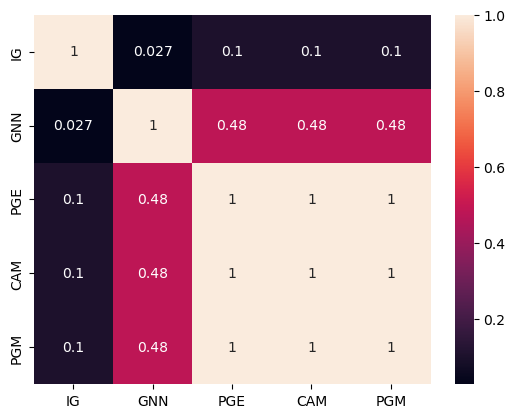

In [34]:
labels = ["IG", "GNN", "PGE", "CAM", "PGM"]
jacard_df = pd.DataFrame(jacard, index = labels, columns = labels)
sns.heatmap(jacard_df, annot=True)